In this notebook, we going to create an electricity anomaly detection system to combat household electricity theft

Since it was hard to find datasets with the data required we created a synthetic database

In [1]:
#packages and dependencies 

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# 1.  Generate the Synthetic Dataset

In [2]:

# Set random seed for reproducibility
np.random.seed(42)

# Create a date range (four years of daily data)
date_range = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')

# Number of households to achieve approximately 500,000 records (500,000 / 1461 ≈ 342 households)
n_households = 342

# Simulate number of people per household (randomly assigning between 1 and 8 people per household)
household_size = np.random.randint(1, 9, size=n_households)

# Base consumption is now a function of household size (larger households consume more on average)
# Use base consumption between 10 kWh (small households) to 30 kWh (large households)
base_consumption = 10 + household_size * np.random.uniform(low=1, high=3, size=n_households)

# Create an empty dictionary to hold the consumption data
consumption_data = {}

for i in range(n_households):
    # Simulate normal consumption with random daily variations
    normal_usage = base_consumption[i] + np.random.normal(loc=0, scale=3, size=len(date_range))
    
    # Introduce anomalies (simulate electricity theft by reducing consumption)
    anomaly_days = np.random.choice(range(len(date_range)), size=10, replace=False)
    normal_usage[anomaly_days] *= np.random.uniform(0.1, 0.5, size=len(anomaly_days))  # Reduce consumption by 50-90%
    
    # Store data in dictionary
    consumption_data[f'household_{i+1}'] = normal_usage

# Simulate daily average temperatures with seasonal variation
# Define temperature trends for each season: winter, spring, summer, fall
# Using rough ranges: winter (-5 to 10°C), spring (5 to 20°C), summer (15 to 35°C), fall (5 to 20°C)
temperatures = []
for date in date_range:
    month = date.month
    if month in [12, 1, 2]:  # Winter months
        avg_temp = np.random.uniform(-5, 10)
    elif month in [3, 4, 5]:  # Spring months
        avg_temp = np.random.uniform(5, 20)
    elif month in [6, 7, 8]:  # Summer months
        avg_temp = np.random.uniform(15, 35)
    else:  # Fall months (September, October, November)
        avg_temp = np.random.uniform(5, 20)
    temperatures.append(avg_temp)

# Create DataFrame for consumption data
data = pd.DataFrame(consumption_data, index=date_range)

# Add temperature data to the DataFrame
data['avg_temperature'] = temperatures

# Melt the DataFrame to get household and date as rows (instead of households as columns)
melted_data = data.reset_index().melt(id_vars=['index', 'avg_temperature'], var_name='household_id', value_name='daily_consumption')

# Rename the 'index' column to 'date' for clarity
melted_data.rename(columns={'index': 'date'}, inplace=True)

# Create household metadata DataFrame (for household size)
metadata = pd.DataFrame({
    'household_id': [f'household_{i+1}' for i in range(n_households)],
    'household_size': household_size,
    'base_consumption': base_consumption
})

# Merge the melted consumption data with the metadata
final_data = pd.merge(melted_data, metadata, on='household_id', how='left')

# Save to a single CSV file
final_data.to_csv('synthetic_household_energy_data_with_metadata.csv', index=False)

print("Dataset with consumption data, temperature, and household metadata saved as 'synthetic_household_energy_data_with_metadata.csv'")


Dataset with consumption data, temperature, and household metadata saved as 'synthetic_household_energy_data_with_metadata.csv'


This code generates a year's worth of daily electricity consumption data for 10 households. Some anomalies (where consumption is unusually low) are injected randomly to simulate electricity theft.

# 2. load and process the synthetic dataset:

In [3]:

# Load the synthetic dataset
data = pd.read_csv('synthetic_household_energy_data_with_metadata.csv', parse_dates=['date'])

# Check the data structure
print(data.head())

        date  avg_temperature household_id  daily_consumption  household_size  \
0 2020-01-01         7.202730  household_1          17.011396               7   
1 2020-01-02         6.122012  household_1          16.385566               7   
2 2020-01-03         3.353670  household_1          18.118662               7   
3 2020-01-04         6.297039  household_1          13.940192               7   
4 2020-01-05         9.245925  household_1          18.254996               7   

   base_consumption  
0          17.23223  
1          17.23223  
2          17.23223  
3          17.23223  
4          17.23223  


# 3. Data preprocessing

a. Aggregating Consumption Data
You can aggregate the daily consumption data for each household into broader periods (e.g., weekly, monthly, or yearly averages) to capture general consumption patterns. Using too detailed data might lead to noisy clustering, while aggregated patterns may highlight broader trends.

In [4]:
# Aggregating the daily consumption data into monthly averages
monthly_data = data.groupby(['household_id', pd.Grouper(key='date', freq='M')]).mean()

# Displaying the first few rows of the aggregated monthly data
monthly_data.head()

avg_temperature  daily_consumption  household_size  \
household_id date                                                             
household_1  2020-01-31         2.747394          17.576203             7.0   
             2020-02-29         2.602917          17.151689             7.0   
             2020-03-31        11.679539          16.761514             7.0   
             2020-04-30        12.151861          17.102105             7.0   
             2020-05-31        12.981391          16.499531             7.0   

                         base_consumption  
household_id date                          
household_1  2020-01-31          17.23223  
             2020-02-29          17.23223  
             2020-03-31          17.23223  
             2020-04-30          17.23223  
             2020-05-31          17.23223

b. Feature Scaling
Since energy consumption might vary drastically across households, you’ll want to normalize the data. Standardizing the data will help make the clustering algorithm more sensitive to relative differences.

In [5]:

# Drop temperature data if clustering only on energy consumption
scaled_data = monthly_data.drop(columns=['avg_temperature'], axis=1)

# Normalize the data (scale each household's data)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaled_data)

# 4. Clustering the Households

a. apply a clustering algorithm to identify households with similar consumption patterns.

K-Means: Efficient for large datasets but requires specifying the number of clusters (k).

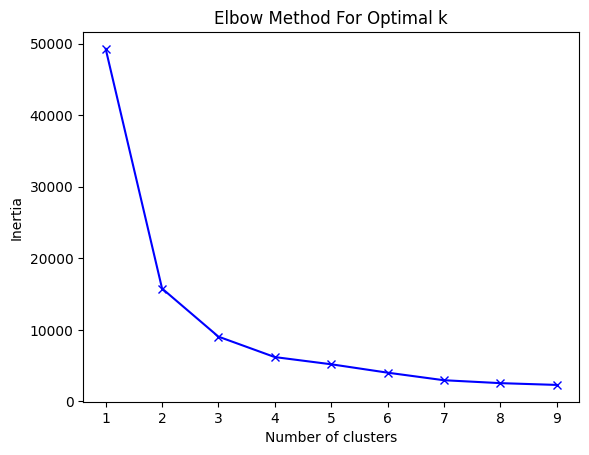

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to determine the number of clusters
inertia = []
K = range(1, 10)  # Check calusters from 1 to 9
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow graph
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

b. Cluster the Households
Once you've selected the number of clusters, apply the K-Means algorithm to segment the households.

In [7]:
# Assuming the optimal number of clusters is determined as k=3 from the elbow method
kmeans = KMeans(n_clusters=4, random_state=42)
monthly_data['cluster'] = kmeans.fit_predict(scaled_data)

c. Merge the clusters back with the original dataset: If you want to visualize the clusters in the daily data (final_data), you should map the clusters from monthly_data back to the daily data.

In [8]:
# Reset index to merge the monthly clusters with the original data
monthly_data.reset_index(inplace=True)

# Merge clusters with original daily data on 'household_id' and 'date' (ensure date aligns with monthly grouping)
final_data = pd.merge(final_data, monthly_data[['household_id', 'date', 'cluster']], 
                      on=['household_id', 'date'], how='left')

# 5. Labeling the Data
To detect electricity theft, you need to label or identify the anomalous consumption patterns within the dataset. Since you've already injected anomalies (reduced consumption on certain days to simulate theft), you can use this information to label those records.

Label Creation:
Add a binary column to flag potential theft cases (1 for theft, 0 for normal consumption). This could be based on the conditions you introduced for reducing consumption (e.g., a significant drop in consumption compared to normal usage).

In [9]:
# Label theft anomalies (assuming that days with a significant drop in consumption are thefts)
final_data['theft_label'] = final_data.apply(
    lambda row: 1 if row['daily_consumption'] < 0.5 * row['base_consumption'] else 0, axis=1
)

# 6. Feature Engineering

To detect anomalies, we create an additional feature that can highlight abnormal behavior. 

In [10]:
# Create a rolling mean and standard deviation for each household's consumption
final_data['rolling_mean_7d'] = final_data.groupby('household_id')['daily_consumption'].transform(lambda x: x.rolling(window=7).mean())
final_data['rolling_std_7d'] = final_data.groupby('household_id')['daily_consumption'].transform(lambda x: x.rolling(window=7).std())

# 7. Modeling for Anomaly Detection 

Unsupervised Anomaly Detection

   a.  Train the IsolationForest on monthly data

In [11]:
# Train an Isolation Forest on the scaled monthly data
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # 1% contamination (anomalies)
monthly_data['anomaly'] = iso_forest.fit_predict(scaled_data)

# Map 1 and -1 to binary values (1 = anomaly, 0 = normal)
monthly_data['anomaly'] = monthly_data['anomaly'].map({1: 0, -1: 1})

b. Merge Anomalies with Daily Data

   To assign the detected monthly anomalies to the daily data, merge monthly_data back to final_data. We'll use household_id and the month of the date column as keys for the merge.

In [12]:
# Extract month and year from the date to align with monthly data
monthly_data.reset_index(inplace=True)
monthly_data['month'] = monthly_data['date'].dt.to_period('M')  # Convert to monthly period

# Create a similar 'month' column in final_data to facilitate merging
final_data['month'] = final_data['date'].dt.to_period('M')

# Merge the monthly anomaly detection results back to the daily final_data
final_data = pd.merge(final_data, monthly_data[['household_id', 'month', 'anomaly']], 
                      on=['household_id', 'month'], how='left')

# Check the merged data with anomalies
print(final_data[final_data['anomaly'] == 1].head())

            date  avg_temperature  household_id  daily_consumption  \
54482 2021-03-01        10.581522  household_38          11.278467   
54483 2021-03-02        19.706589  household_38          12.566392   
54484 2021-03-03        14.891750  household_38          12.813551   
54485 2021-03-04        13.882940  household_38           8.938393   
54486 2021-03-05         5.173517  household_38          14.736464   

       household_size  base_consumption  cluster  theft_label  \
54482               1         11.010123      NaN            0   
54483               1         11.010123      NaN            0   
54484               1         11.010123      NaN            0   
54485               1         11.010123      NaN            0   
54486               1         11.010123      NaN            0   

       rolling_mean_7d  rolling_std_7d    month  anomaly  
54482        11.910596        2.673829  2021-03        1  
54483        11.964828        2.684194  2021-03        1  
54484      

b. Supervised Classification

Random Forest Classifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98760
           1       1.00      0.79      0.88      1173

    accuracy                           1.00     99933
   macro avg       1.00      0.89      0.94     99933
weighted avg       1.00      1.00      1.00     99933



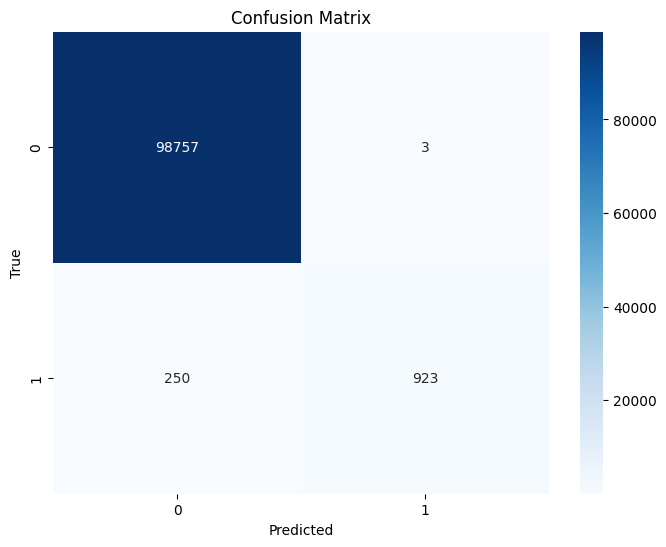

In [16]:
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import classification_report, confusion_matrix  
import matplotlib.pyplot as plt  
import seaborn as sns  

# Define features and labels  
X = final_data.drop(columns=['theft_label', 'household_id', 'date'])  
y = final_data['theft_label']  

# Split the data into training and testing sets  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# Train the Random Forest  
rf_clf = RandomForestClassifier(random_state=42)  
rf_clf.fit(X_train, y_train)  

# Make predictions  
y_pred = rf_clf.predict(X_test)  

# Evaluate the model  
print(classification_report(y_test, y_pred))  

# Plot the confusion matrix  
cm = confusion_matrix(y_test, y_pred)  
plt.figure(figsize=(8, 6))  
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')  
plt.title('Confusion Matrix')  
plt.xlabel('Predicted')  
plt.ylabel('True')  
plt.show()  